In [2]:
import torch
from detectron2._C import box_iou_rotated, nms_rotated

In [3]:
mvtec = torch.load("../datasets/mvtec.pth")

In [4]:
from ops.boxes import obb2poly, hbb2obb

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
from shapely import Polygon

In [6]:
def iou(polygon1, polygon2):
    intersect = polygon1.intersection(polygon2).area
    union = polygon1.union(polygon2).area
    iou = intersect / union
    return iou

def diff_iou(data, data_idx = 0):
    oboxes = data['train'][data_idx]['oboxes']
    polys = data['train'][data_idx]['polygons']
    polys = polys.numpy().reshape(-1, 4, 2)
    
    hboxes = data['train'][data_idx]['bboxes']
    
    converted_oboxes = hbb2obb(hboxes)
    converted_oboxes_poly = obb2poly(converted_oboxes)
    converted_oboxes_poly = converted_oboxes_poly.numpy().reshape(-1, 4, 2)
    
    n = len(polys)

    poly_ious = torch.empty((n, n), dtype=torch.float32)
    for i in range(n):
        for j in range(n):
            poly_ious[i, j] = iou(Polygon(polys[i]), Polygon(converted_oboxes_poly[j]))
    
    oboxes_ious = box_iou_rotated(oboxes, converted_oboxes)
    poly_ious = poly_ious.diag()
    oboxes_ious = oboxes_ious.diag()
    return torch.abs(poly_ious-oboxes_ious).diag().mean(), torch.isclose(poly_ious, oboxes_ious)
    

In [7]:
avg_l1 = torch.tensor(0.0)
for i in range(len(mvtec)):
    l1, is_close = diff_iou(mvtec, data_idx=i)
    avg_l1 += l1
avg_l1 /= len(mvtec)
print(avg_l1)

tensor(5.8615e-05)


/usr/local/lib/python3.10/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [16]:
data_idx = 0
data = mvtec['train'][data_idx]
hboxes = data['bboxes']
oboxes_from_hboxes = hbb2obb(hboxes)
poly_from_oboxes = obb2poly(oboxes_from_hboxes)
image_path = data['image_path']
from PIL import Image, ImageDraw
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
for hbox in hboxes:
    draw.rectangle(hbox.tolist(), outline='red', width=5)
    
for poly_obox in poly_from_oboxes:
    draw.polygon(poly_obox.tolist(), outline='blue', width=3)



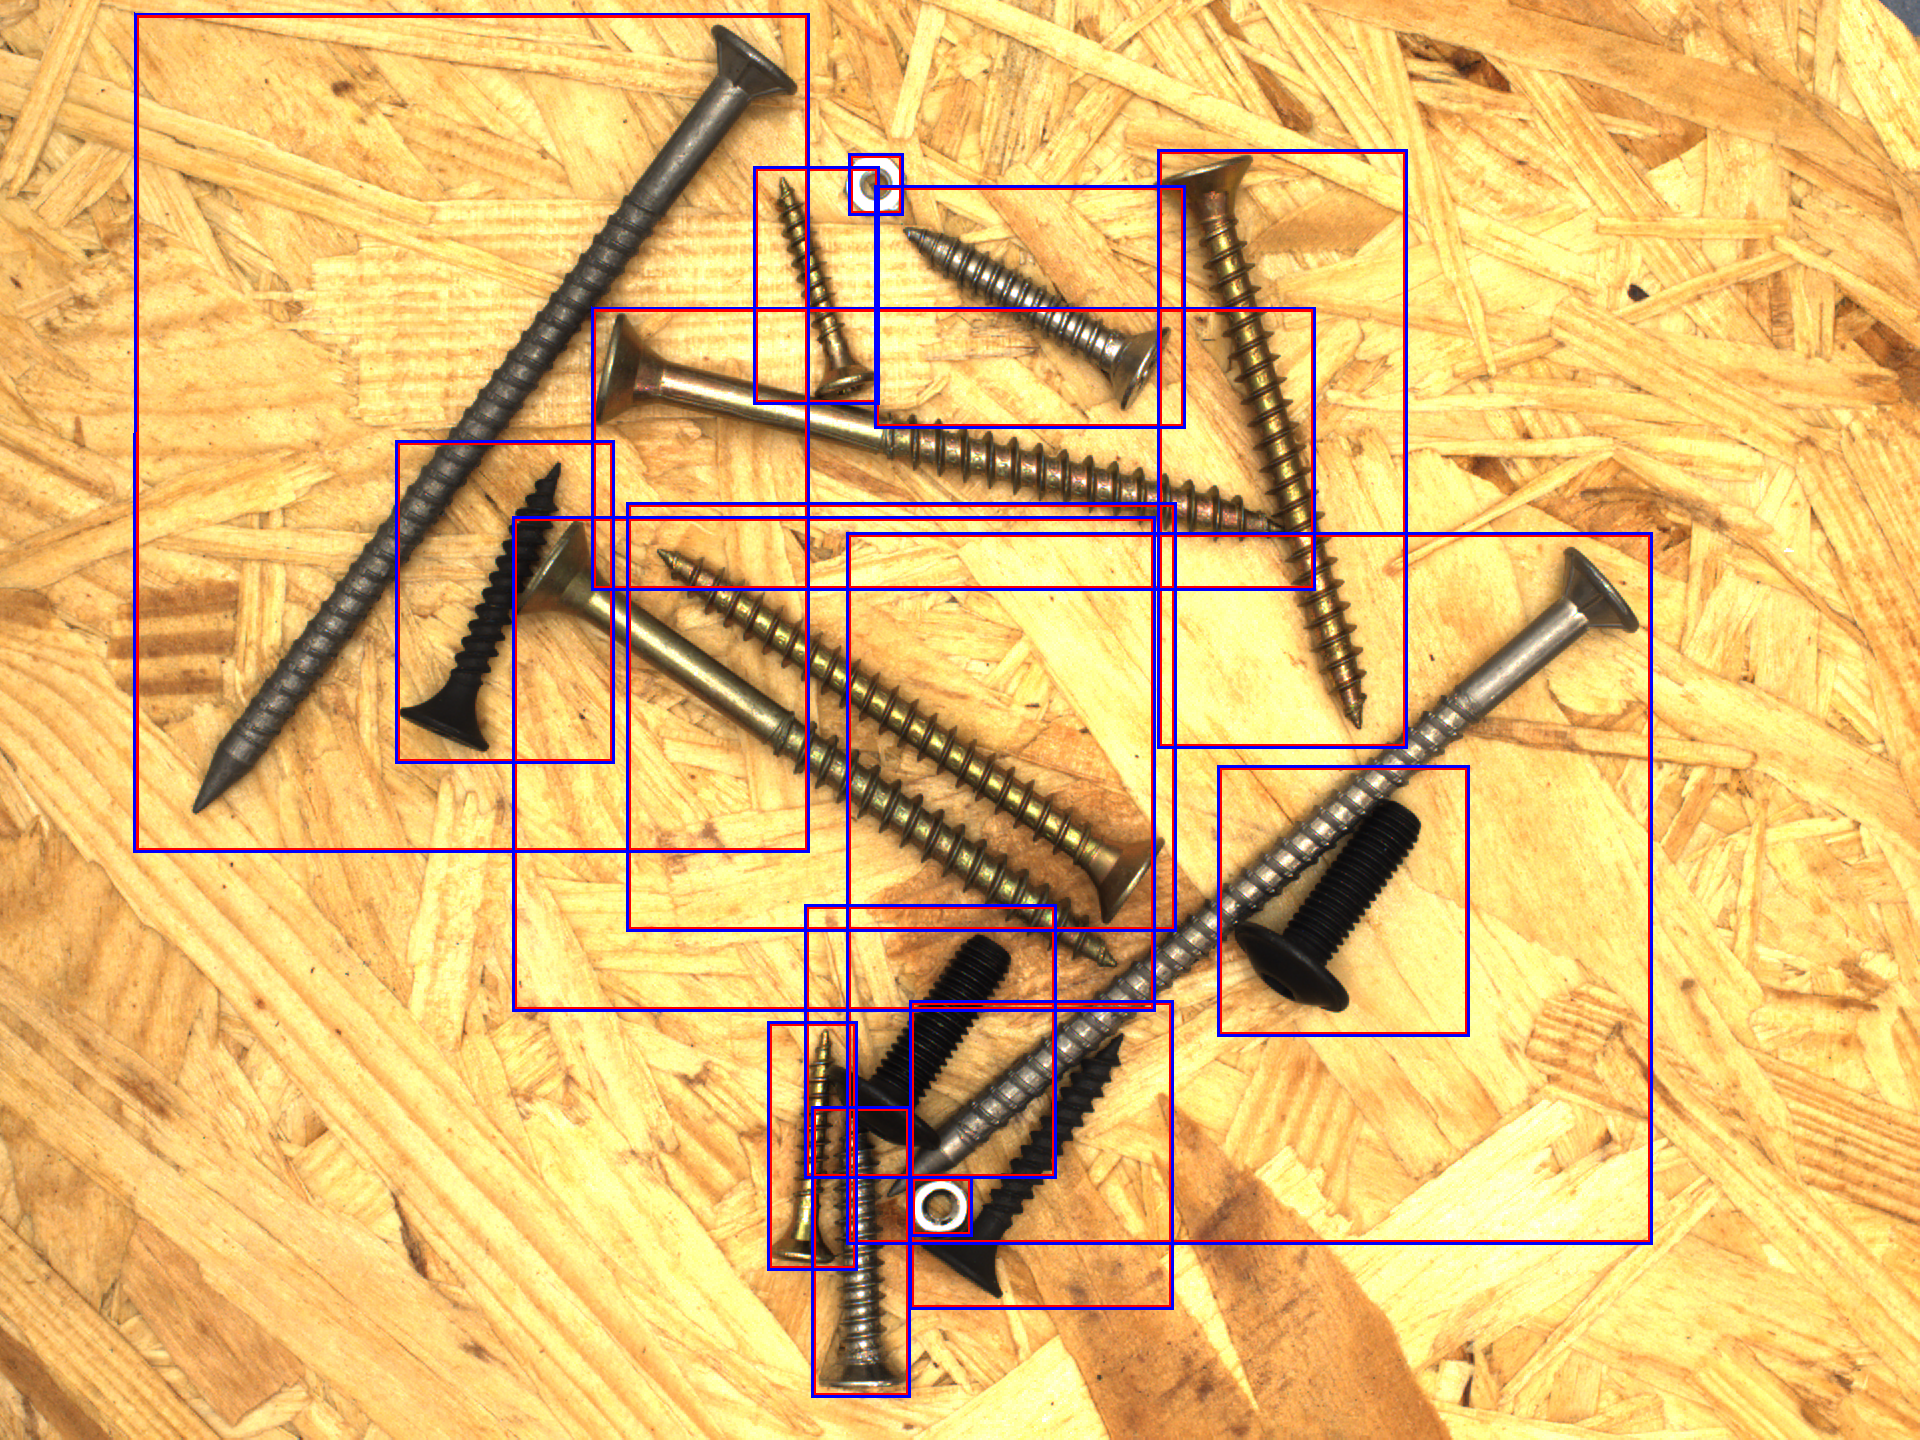

In [17]:
image

In [22]:
nms_rotated(oboxes_from_hboxes, torch.rand(size=[oboxes_from_hboxes.shape[0],]), torch.randint(0, 10, size=[oboxes_from_hboxes.shape[0],]).float())

TypeError: nms_rotated(): incompatible function arguments. The following argument types are supported:
    1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: float) -> torch.Tensor

Invoked with: tensor([[ 875.5000,  184.0000,   62.0000,   55.0000,    1.5708],
        [1282.0000,  448.5000,  599.0000,  250.0000,    1.5708],
        [1249.0000,  888.0000,  712.0000,  806.0000,    1.5708],
        [ 471.5000,  432.5000,  839.0000,  675.0000,    1.5708],
        [ 941.0000, 1206.0000,   60.0000,   62.0000,    1.5708],
        [1343.0000,  900.5000,  271.0000,  252.0000,    1.5708],
        [ 930.0000, 1041.0000,  274.0000,  252.0000,    1.5708],
        [ 504.5000,  601.5000,  323.0000,  219.0000,    1.5708],
        [1041.0000, 1154.5000,  309.0000,  264.0000,    1.5708],
        [ 860.5000, 1251.5000,  291.0000,   99.0000,    1.5708],
        [ 812.0000, 1145.5000,  249.0000,   90.0000,    1.5708],
        [1029.5000,  306.5000,  243.0000,  311.0000,    1.5708],
        [ 816.0000,  285.0000,  238.0000,  126.0000,    1.5708],
        [ 953.0000,  448.5000,  283.0000,  724.0000,    1.5708],
        [ 901.0000,  716.5000,  429.0000,  550.0000,    1.5708],
        [ 833.5000,  763.5000,  495.0000,  643.0000,    1.5708]]), tensor([0.8890, 0.0011, 0.2416, 0.9981, 0.6903, 0.5479, 0.2210, 0.6394, 0.0247,
        0.0991, 0.1836, 0.1491, 0.3070, 0.5587, 0.6295, 0.2407]), tensor([3., 7., 8., 9., 4., 7., 9., 0., 2., 5., 7., 1., 9., 6., 8., 5.])

In [1]:
import sys
sys.path.append("..")

In [2]:
from torchvision.ops import MultiScaleRoIAlign
from ops.poolers import MultiScaleRotatedRoIAlign
import torch

In [18]:
rroi_align = MultiScaleRotatedRoIAlign(['feat1', 'feat3'], 3, 2)
roi_align = MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
i = {}
i['feat1'] = torch.rand(1, 5, 64, 64)
i['feat3'] = torch.rand(1, 5, 16, 16)
num_rois = 1
# create some random rotated bounding boxes
boxes = torch.rand(num_rois, 4) * 256
boxes[:, 2:] += boxes[:, :2]

angles = torch.ones(num_rois, 1) * - torch.pi / 2 
cx = (boxes[:, 0:1] + boxes[:, 2:3]) / 2
cy = (boxes[:, 1:2] + boxes[:, 3:4]) / 2
w = boxes[:, 2:3] - boxes[:, 0:1]
h = boxes[:, 3:4] - boxes[:, 1:2]
boxes_with_angles = torch.cat((cx, cy, w, h, angles), dim=1)
# original image size, before computing the feature maps
image_sizes = [(512, 512)]
rroi = rroi_align(i, [boxes_with_angles], image_sizes)
roi = roi_align(i, [boxes], image_sizes)

In [19]:
boxes

tensor([[ 42.3359, 214.7271, 123.5249, 441.0070]])

In [20]:
boxes_with_angles

tensor([[ 82.9304, 327.8670,  81.1890, 226.2799,  -1.5708]])

In [21]:
roi

tensor([[[[0.4307, 0.4571, 0.7179],
          [0.4273, 0.4487, 0.4683],
          [0.4526, 0.5256, 0.5608]],

         [[0.6916, 0.6256, 0.4431],
          [0.6694, 0.4380, 0.5833],
          [0.7337, 0.4203, 0.4462]],

         [[0.4508, 0.6953, 0.4853],
          [0.3822, 0.5267, 0.6466],
          [0.4055, 0.6169, 0.5113]],

         [[0.5702, 0.3777, 0.4301],
          [0.6957, 0.5068, 0.5952],
          [0.4947, 0.3939, 0.5346]],

         [[0.3862, 0.3850, 0.5619],
          [0.3632, 0.3751, 0.5013],
          [0.3369, 0.4638, 0.6106]]]])

In [22]:
rroi

tensor([[[[0.5850, 0.5407, 0.3320],
          [0.5691, 0.4336, 0.4929],
          [0.1761, 0.2812, 0.2672]],

         [[0.4529, 0.4387, 0.3252],
          [0.5551, 0.5376, 0.6540],
          [0.2108, 0.2861, 0.1181]],

         [[0.5517, 0.5447, 0.5999],
          [0.5530, 0.5521, 0.4323],
          [0.1092, 0.1766, 0.2565]],

         [[0.5815, 0.4673, 0.5611],
          [0.6150, 0.4118, 0.5725],
          [0.1521, 0.2891, 0.3475]],

         [[0.5598, 0.5073, 0.6844],
          [0.5794, 0.6171, 0.4332],
          [0.4367, 0.2397, 0.1588]]]])